# Positioning the Outdoor UEs using 5G Urban Micro cell sites based Uplink Time Difference of Arrival (UL-TDoA) method


Uplink Time Difference of Arrival (UL-TDoA) positioning in 5G networks is a technique used to determine the location of a user equipment (UE) by measuring the time difference of arrival of signals transmitted from multiple base stations (gNBs). Here's an overview of UL-TDoA based positioning in 5G networks:

1. **Principle**: UL-TDoA positioning relies on the principle that signals transmitted from the UE reach multiple gNBs at slightly different times due to variations in signal propagation delays. By accurately measuring these time differences of arrival at the gNBs, the UE's location can be determined using trilateration or multilateration techniques.

2. **Reference Signals**: To enable UL-TDoA positioning, the 5G network periodically transmits reference signals from gNBs with known timing and synchronization. These reference signals are received by the UE and used to accurately measure the time of arrival at each gNB.

3. **Measurement Procedure**: When the UE needs to determine its position, it measures the time of arrival of the reference signals from multiple neighboring gNBs. These time measurements are typically made using high-precision timing mechanisms, such as GPS or atomic clocks, to achieve sub-meter or even centimeter-level accuracy.

4. **Time Difference Calculation**: Once the time of arrival measurements are obtained from multiple gNBs, the UE calculates the time differences between pairs of gNBs. These time differences are then converted into distance differences using the known speed of light in the propagation medium.

5. **Position Calculation**: Using the distance differences obtained from the time differences of arrival, along with the known locations of the gNBs, the UE's position can be calculated using trilateration or multilateration algorithms. These algorithms estimate the UE's location by intersecting spheres or hyperboloids corresponding to the distance differences from each gNB.

6. **Challenges and Considerations**: UL-TDoA positioning in 5G networks faces challenges such as multipath propagation, non-line-of-sight (NLOS) conditions, synchronization errors, and signal interference. Advanced signal processing techniques and robust algorithms are employed to mitigate these challenges and improve the accuracy and reliability of positioning estimates.


Overall, UL-TDoA based positioning in 5G networks offers ultra-accurate location determination capabilities, making it suitable for applications requiring precise positioning, such as emergency services, asset tracking, and indoor navigation.


**Table of Content**

* [Import Libraries](#Import-Libraries)
    * [Import Basic Python Libraries](#Import-Basic-Python-Libraries)
    * [Import 5G Toolkit Modules](#Import-5G-Toolkit-Libraries)
* [Learning to Demap the Symbols](#Learning-to-Demap-the-Symbols)
* [Simulation Parameters](#Simulation-Parameters)
* [Generate Wireless Channels](#Generate-Wireless-Channels)
* [SRS Configurations](#SRS-Configurations)
* [Slot by Slot Simulation](#Slot-by-Slot-Simulation)
* [Position Estimation: Based on UL ToA](#Position-Estimation:-Based-on-UL-ToA)
* [Visualization of Estimated Position](#Visualization-of-Estimated-Position)
* [Performance Analysis of Positioning Error for ToA based method](#Performance-Analysis-of-Positioning-Error-for-ToA-based-method)
* [Performance Analysis: For 2000 UEs](#Performance-Analysis:-For-2000-UEs)



## Import Libraries

### Import Basic Python Libraries

In [1]:
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# %matplotlib widget
import matplotlib.pyplot  as plt
import matplotlib.patches as mpatches
import matplotlib as mpl

import numpy      as np
import numpy.matlib
import scipy      as sp
import scipy.io   as spio
import scipy.constants
from   scipy import interpolate

### Import 5G Toolkit Libraries

In [2]:
import sys
sys.path.append("../../../")

from toolkit5G.ChannelModels      import AntennaArrays, SimulationLayout, ParameterGenerator, ChannelGenerator
from toolkit5G.ResourceMapping    import ResourceMapperSRS
from toolkit5G.ReceiverAlgorithms import ChannelEstimationSRS
from toolkit5G.Positioning        import ToAEstimation, PositionEstimation, LeastSquareTDoA, LeastSquareToA
from toolkit5G.ChannelProcessing  import AddNoise

## Simulation Parameters


|Parameters|Values|
| :- | -:  |
| Positioning Method  | UL-TDoA  |
| Parameter Estimation Method  | ESPRIT  |
| Optimization Method | Least Squares |
| Carrier Frequency | 3.6 GHz |
| Bandwidth | 100 MHz |
| Subcarrier Spacing | 300 kHz|
| Terrain | Indoor-Factory (UMi) |
|Channel State Information |Zero Forcing + Spline Interpolation|
| Reference Signal | Sounding Reference Signal for Positioning (SRS-P) |
|Simulation Type| System Level Simulation|

In [3]:
## Simulation Parameters

propTerrain      = "UMi"         # Propagation Scenario or Terrain for BS-UE links
carrierFrequency = 3.6*10**9         # Array of two carrier frequencies in GHz
scs              = 30*10**3
Nfft             = 4096
numOfBSs         = 21 # number of BSs
nBSs             = np.prod(numOfBSs)
nUEs             = 128             # number of UEs
numRBs           = 272
numSlots         = 1

## Generate Wireless Channels

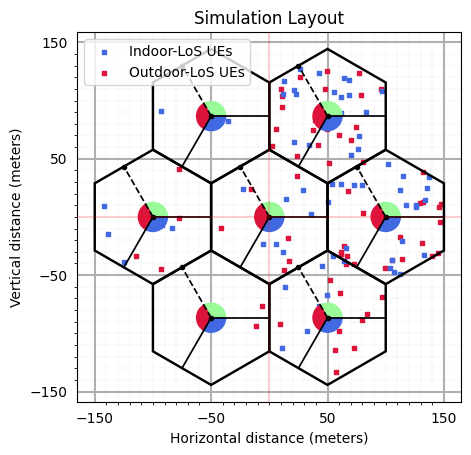

[Warning]: Pathloss model for UMi is defined only for  2D distances 'd2D' between 10m and 5Km! Some distances are from outside this interval!
Ignoring for now but might result in unexpected behaviour!
Channel Parameters Generated!
Channel Coefficient Generated!
OFDM Channel Generated!


In [4]:
## Generate the Wireless Channel

# Antenna Array at UE side
# assuming antenna element type to be "OMNI"
# with 2 panel and 2 single polarized antenna element per panel.
ueAntArray = AntennaArrays(antennaType = "OMNI",  centerFrequency = carrierFrequency, arrayStructure  = np.array([1,1,2,2,1]))
ueAntArray()

# # Radiation Pattern of Rx antenna element
# ueAntArray.displayAntennaRadiationPattern()


# Antenna Array at BS side
# assuming antenna element type to be "3GPP_38.901", a parabolic antenna
# with 4 panel and 4 single polarized antenna element per panel.
bsAntArray = AntennaArrays(antennaType = "3GPP_38.901", centerFrequency = carrierFrequency, arrayStructure  = np.array([1,1,8,4,1]))
bsAntArray()

# # Radiation Pattern of Tx antenna element
# bsAntArray[0].displayAntennaRadiationPattern()

# Layout Parameters
isd                  = 100          # inter site distance
minDist              = 10          # min distance between each UE and BS
ueHt                 = 1.5         # UE height
bsHt                 = 10          # BS height
bslayoutType         = "Hexagonal" # BS layout type
ueDropType           = "Hexagonal" # UE drop type
htDist               = "equal"       # UE height distribution
ueDist               = "random"       # UE Distribution per site
nSectorsPerSite      = 3             # number of sectors per site
maxNumFloors         = 1             # Max number of floors in an indoor object
minNumFloors         = 1             # Min number of floors in an indoor object
heightOfRoom         = 5.1             # height of room or ceiling in meters
indoorUEfract        = 0.5           # Fraction of UEs located indoor
lengthOfIndoorObject = 3             # length of indoor object typically having rectangular geometry
widthOfIndoorObject  = 3             # width of indoor object
forceLOS             = True          # boolen flag if true forces every link to be in LOS state
# forceLOS             = False       # boolen flag if true forces every link to be in LOS state

# simulation layout object
simLayoutObj = SimulationLayout(numOfBS = numOfBSs,
                                numOfUE = nUEs,
                                heightOfBS = bsHt,
                                heightOfUE = ueHt,
                                ISD = isd,
                                layoutType = bslayoutType,
                                layoutWidth = 30,
                                layoutLength = 120,
                                ueDropMethod = ueDropType,
                                UEdistibution = ueDist,
                                UEheightDistribution = htDist,
                                numOfSectorsPerSite = nSectorsPerSite,
                                ueRoute = None)

simLayoutObj(terrain = propTerrain,
             carrierFreq = carrierFrequency,
             ueAntennaArray = ueAntArray,
             bsAntennaArray = bsAntArray,
             indoorUEfraction = indoorUEfract,
             heightOfRoom = heightOfRoom,
             lengthOfIndoorObject = lengthOfIndoorObject,
             widthOfIndoorObject = widthOfIndoorObject,
             forceLOS = forceLOS)

# displaying the topology of simulation layout
fig, ax = simLayoutObj.display2DTopology()
ax.set_xlabel("x-coordinates (m)")
ax.set_ylabel("y-coordinates (m)")
ax.set_title("Simulation Topology")
# ax.axhline(y=-0.5*isd*numOfBSs[1], xmin=10/140, xmax=130/140, color="k")
# ax.axhline(y= 0.5*isd*numOfBSs[1], xmin=10/140, xmax=130/140, color="k")
# ax.axvline(x=-0.5*isd*numOfBSs[0], ymin=10/140, ymax=130/140, color="k")
# ax.axvline(x= 0.5*isd*numOfBSs[0], ymin=10/140, ymax=130/140, color="k")

paramGen = simLayoutObj.getParameterGenerator()
print("Channel Parameters Generated!")

# paramGen.displayClusters((0,0,0), rayIndex = 0)
channel = paramGen.getChannel()
print("Channel Coefficient Generated!")
Hf      = channel.ofdm(scs, Nfft)[0]
print("OFDM Channel Generated!")

Nt        = bsAntArray.numAntennas # Number of BS Antennas
Nr        = ueAntArray.numAntennas

## SRS Configurations

In [5]:
## SRS Configurations
purpose			    = "positioning"
nrofSRS_Ports		= 1
transmissionComb	= 4
nrofSymbols		    = 12
startPosition		= 2
repetitionFactor	= 1
nrOfCyclicShift		= 1
groupOrSequenceHopping	= "neither"
sequenceId		        = np.arange(nUEs)

systemFrameNumber	    = 0
resourceType		    = "periodic"
subcarrierSpacing 	    = scs

bSRS 			        = 0
cSRS 			        = 61
bHop 			        = 0

freqScalingFactor 	    = 1
startRBIndex 		    = 0
enableStartRBHopping 	= False
freqDomainShift 	    = 0
freqDomainPosition 	    = 0
srsPeriodicityInSlots 	= 1
srsOffsetInSlots 		= 0
betaSRS 		        = 1
resourceGridSizeinRBs 	= numRBs
Bandwidth               = resourceGridSizeinRBs*12*scs

## Slot by Slot Simulation

- Schedule a certain UEs for SRS transmission in each slot.
- Beamform the slot Grid.
- Pass the beamformed Grid through the wireless channel.
    - Consider inter-user interference.
- Extract the resource Grid.
- Estimate the channel between the scheduled users and each BS.
    - Estimate the channel using LS estimator.
    - Interpolate the channel for un-scheduled REs in the slot Grid.
- Estimate the time of arrival (ToA) for each UE-BS link.

In [6]:
print("***********  Transmission Grid Beamformed *********** ")
numRepetition    = 1
numSlotsPerFrame = np.int32(10*(15000/scs))
numUEsPerSlot    = transmissionComb
numSlots         = np.int32(np.ceil(nUEs*numRepetition/transmissionComb))
frameIndices     = np.int32(np.floor(np.arange(numUEsPerSlot*numRepetition)/transmissionComb)%numSlotsPerFrame)
slotIndices      = np.int32(np.floor(np.floor(np.arange(numUEsPerSlot*numRepetition)/transmissionComb)/numSlotsPerFrame))
combOffset       = np.int32(np.arange(numUEsPerSlot))

ToAe              = np.zeros((nBSs,nUEs))

for ns in range(numSlots):
    
    ## SRS Grid Generation

    srsGrid      = np.zeros((numUEsPerSlot, 14, numRBs*12), dtype=np.complex64)
    srsObject    = np.empty((numUEsPerSlot), dtype=object)

    for nue in range(numUEsPerSlot):
        srsObject[nue]   = ResourceMapperSRS(nrofSRS_Ports, transmissionComb, nrofSymbols, startPosition,
                                             repetitionFactor, nrOfCyclicShift, groupOrSequenceHopping, 
                                             sequenceId[nue], combOffset[nue], ns, frameIndices[nue], 
                                             resourceType, purpose, subcarrierSpacing)

        srsGrid[nue] = srsObject[nue](bSRS, cSRS, bHop, freqScalingFactor, startRBIndex, 
                                          enableStartRBHopping, freqDomainShift, freqDomainPosition, 
                                          srsPeriodicityInSlots, srsOffsetInSlots, betaSRS, 
                                          resourceGridSizeinRBs)[0,0,0]

    XGrid     = np.zeros((numUEsPerSlot, 14, Nfft), dtype=np.complex64)
    bwpOffset = np.random.randint(Nfft-resourceGridSizeinRBs*12)

    print("***********  SRS Grid Generated *********** ")
    ## Load the resource grid to Transmission Grid
    XGrid[...,bwpOffset:(bwpOffset+resourceGridSizeinRBs*12)] = srsGrid

    print("***********  Transmission Grid Generated *********** ")

    del srsGrid

    ## Beamforming
    # Beamforming angles
    # Inter-element spacing in vertical and horizontal
    Pt_dBm= 23
    Pt    = 10**(0.1*(Pt_dBm-30))
    lamda = 3*10**8/carrierFrequency
    d     = 0.5/lamda
    theta = 0
    # Wt    = np.sqrt(Pt/Nt)*np.exp(1j*2*np.pi*d*np.cos(theta)/(lamda*Nt)*np.arange(0,Nt))
    # Xf    = Wt.reshape(-1,1,1)*XGrid1
    Xf    = (transmissionComb*Pt/Nr)*XGrid[..., np.newaxis].repeat(Nr, axis = -1)
    del XGrid
    
    ueIndices     = np.arange(ns*numUEsPerSlot, (ns+1)*numUEsPerSlot)
    ## Pass through channel
    Yf = (Hf[:,:,ueIndices].transpose(1,2,0,3,5,4)@Xf[np.newaxis,...,np.newaxis]).sum(1)

    print("***********  ["+str(ns)+"]-Passed Through Channel *********** ")

    ## Add Noise
    BoltzmanConst = 1.380649*(10**(-23))
    temperature   = 300
    noisePower    = BoltzmanConst*temperature*scs
#     noisePower    = 0
    kppm          = 0
    fCFO          = kppm*(np.random.rand()-0.5)*carrierFrequency*(10**(-6)); # fCFO = CFO*subcarrierSpacing
    CFO           = (fCFO/scs)/Nfft
    ##Yf            = AddNoise(True)(Y, noisePower, CFO)

    # Yf            = AddNoise(False)(Y, noisePower, 0)    #Added
    Yf            = np.complex64(Yf + np.sqrt(0.5*noisePower)*(np.random.standard_normal(Yf.shape) + 1j*np.random.standard_normal(Yf.shape)))

    print("***********  ["+str(ns)+"]-Noise Added *********** ")

    ## Extract Resource Grid
    rxGrid = Yf[...,bwpOffset:(bwpOffset+resourceGridSizeinRBs*12),:,0].transpose(0,3,1,2)

    print("***********  ["+str(ns)+"]-Resource Grid Extracted *********** ")

    ## Channel Estimation and Interpolation
    Hfest  = np.zeros((nBSs, numUEsPerSlot, Nt, 14, rxGrid.shape[-1]), dtype = np.complex64)
    chEST  = ChannelEstimationSRS()
    chGrid = rxGrid.reshape(nBSs*Nt,14,-1)[:,np.newaxis,np.newaxis,np.newaxis]

    interpolatorType = "Linear" # "Spline", "Linear", "Cubic"

    for nue in range(numUEsPerSlot):
        print("UE-Index: "+str(ueIndices[nue])+" | slot-Index: "+str(ns))

        Hfest[:,nue] = chEST(chGrid, srsObject[nue], interpolatorType)[:,0,0,0].reshape(nBSs,Nt,14,-1)

    Hest = Hfest.sum(-2)/14

    print("***********  ["+str(ns)+"]-Channel Estimated *********** ")

    ## ToA Estimation
    toaEstimation = ToAEstimation("ESPRIT", Hest[0, 0].T.shape)
    
    
    Lpath         = 2
    for nbs in range(nBSs):
        for nue in range(numUEsPerSlot):
            print("(nbs, nue): ("+str(nbs)+", "+str(ueIndices[nue])+")")
            delayEstimates = np.sort(toaEstimation(Hest[nbs, nue].T,
                                                   Lpath,
                                                   subCarrierSpacing = scs))
            delayEstimates = delayEstimates[delayEstimates > 0]
            K = Lpath
            while((delayEstimates.size==0) or (delayEstimates[0]<=0 and K < 12)):
                K = K + 1
                delayEstimates = np.sort(toaEstimation(Hest[nbs, nue].T,
                                                       numberOfPath = K,
                                                       subCarrierSpacing = scs))
                delayEstimates = delayEstimates[delayEstimates > 0]
            if(delayEstimates.size == 0):
                ToAe[nbs, ueIndices[nue]] = 10**-9
            else:
                ToAe[nbs, ueIndices[nue]] = delayEstimates[0]

    print("***********  ["+str(ns)+"]-ToA Estimated *********** ")    



***********  Transmission Grid Beamformed *********** 
***********  SRS Grid Generated *********** 
***********  Transmission Grid Generated *********** 
***********  [0]-Passed Through Channel *********** 
***********  [0]-Noise Added *********** 
***********  [0]-Resource Grid Extracted *********** 
UE-Index: 0 | slot-Index: 0
UE-Index: 1 | slot-Index: 0
UE-Index: 2 | slot-Index: 0
UE-Index: 3 | slot-Index: 0
***********  [0]-Channel Estimated *********** 
(nbs, nue): (0, 0)
(nbs, nue): (0, 1)
(nbs, nue): (0, 2)
(nbs, nue): (0, 3)
(nbs, nue): (1, 0)
(nbs, nue): (1, 1)
(nbs, nue): (1, 2)
(nbs, nue): (1, 3)
(nbs, nue): (2, 0)
(nbs, nue): (2, 1)
(nbs, nue): (2, 2)
(nbs, nue): (2, 3)
(nbs, nue): (3, 0)
(nbs, nue): (3, 1)
(nbs, nue): (3, 2)
(nbs, nue): (3, 3)
(nbs, nue): (4, 0)
(nbs, nue): (4, 1)
(nbs, nue): (4, 2)
(nbs, nue): (4, 3)
(nbs, nue): (5, 0)
(nbs, nue): (5, 1)
(nbs, nue): (5, 2)
(nbs, nue): (5, 3)
(nbs, nue): (6, 0)
(nbs, nue): (6, 1)
(nbs, nue): (6, 2)
(nbs, nue): (6, 3)
(nbs,

(nbs, nue): (17, 13)
(nbs, nue): (17, 14)
(nbs, nue): (17, 15)
(nbs, nue): (18, 12)
(nbs, nue): (18, 13)
(nbs, nue): (18, 14)
(nbs, nue): (18, 15)
(nbs, nue): (19, 12)
(nbs, nue): (19, 13)
(nbs, nue): (19, 14)
(nbs, nue): (19, 15)
(nbs, nue): (20, 12)
(nbs, nue): (20, 13)
(nbs, nue): (20, 14)
(nbs, nue): (20, 15)
***********  [3]-ToA Estimated *********** 
***********  SRS Grid Generated *********** 
***********  Transmission Grid Generated *********** 
***********  [4]-Passed Through Channel *********** 
***********  [4]-Noise Added *********** 
***********  [4]-Resource Grid Extracted *********** 
UE-Index: 16 | slot-Index: 4
UE-Index: 17 | slot-Index: 4
UE-Index: 18 | slot-Index: 4
UE-Index: 19 | slot-Index: 4
***********  [4]-Channel Estimated *********** 
(nbs, nue): (0, 16)
(nbs, nue): (0, 17)
(nbs, nue): (0, 18)
(nbs, nue): (0, 19)
(nbs, nue): (1, 16)
(nbs, nue): (1, 17)
(nbs, nue): (1, 18)
(nbs, nue): (1, 19)
(nbs, nue): (2, 16)
(nbs, nue): (2, 17)
(nbs, nue): (2, 18)
(nbs, nue

(nbs, nue): (11, 28)
(nbs, nue): (11, 29)
(nbs, nue): (11, 30)
(nbs, nue): (11, 31)
(nbs, nue): (12, 28)
(nbs, nue): (12, 29)
(nbs, nue): (12, 30)
(nbs, nue): (12, 31)
(nbs, nue): (13, 28)
(nbs, nue): (13, 29)
(nbs, nue): (13, 30)
(nbs, nue): (13, 31)
(nbs, nue): (14, 28)
(nbs, nue): (14, 29)
(nbs, nue): (14, 30)
(nbs, nue): (14, 31)
(nbs, nue): (15, 28)
(nbs, nue): (15, 29)
(nbs, nue): (15, 30)
(nbs, nue): (15, 31)
(nbs, nue): (16, 28)
(nbs, nue): (16, 29)
(nbs, nue): (16, 30)
(nbs, nue): (16, 31)
(nbs, nue): (17, 28)
(nbs, nue): (17, 29)
(nbs, nue): (17, 30)
(nbs, nue): (17, 31)
(nbs, nue): (18, 28)
(nbs, nue): (18, 29)
(nbs, nue): (18, 30)
(nbs, nue): (18, 31)
(nbs, nue): (19, 28)
(nbs, nue): (19, 29)
(nbs, nue): (19, 30)
(nbs, nue): (19, 31)
(nbs, nue): (20, 28)
(nbs, nue): (20, 29)
(nbs, nue): (20, 30)
(nbs, nue): (20, 31)
***********  [7]-ToA Estimated *********** 
***********  SRS Grid Generated *********** 
***********  Transmission Grid Generated *********** 
***********  [8]-

(nbs, nue): (4, 45)
(nbs, nue): (4, 46)
(nbs, nue): (4, 47)
(nbs, nue): (5, 44)
(nbs, nue): (5, 45)
(nbs, nue): (5, 46)
(nbs, nue): (5, 47)
(nbs, nue): (6, 44)
(nbs, nue): (6, 45)
(nbs, nue): (6, 46)
(nbs, nue): (6, 47)
(nbs, nue): (7, 44)
(nbs, nue): (7, 45)
(nbs, nue): (7, 46)
(nbs, nue): (7, 47)
(nbs, nue): (8, 44)
(nbs, nue): (8, 45)
(nbs, nue): (8, 46)
(nbs, nue): (8, 47)
(nbs, nue): (9, 44)
(nbs, nue): (9, 45)
(nbs, nue): (9, 46)
(nbs, nue): (9, 47)
(nbs, nue): (10, 44)
(nbs, nue): (10, 45)
(nbs, nue): (10, 46)
(nbs, nue): (10, 47)
(nbs, nue): (11, 44)
(nbs, nue): (11, 45)
(nbs, nue): (11, 46)
(nbs, nue): (11, 47)
(nbs, nue): (12, 44)
(nbs, nue): (12, 45)
(nbs, nue): (12, 46)
(nbs, nue): (12, 47)
(nbs, nue): (13, 44)
(nbs, nue): (13, 45)
(nbs, nue): (13, 46)
(nbs, nue): (13, 47)
(nbs, nue): (14, 44)
(nbs, nue): (14, 45)
(nbs, nue): (14, 46)
(nbs, nue): (14, 47)
(nbs, nue): (15, 44)
(nbs, nue): (15, 45)
(nbs, nue): (15, 46)
(nbs, nue): (15, 47)
(nbs, nue): (16, 44)
(nbs, nue): (16

UE-Index: 61 | slot-Index: 15
UE-Index: 62 | slot-Index: 15
UE-Index: 63 | slot-Index: 15
***********  [15]-Channel Estimated *********** 
(nbs, nue): (0, 60)
(nbs, nue): (0, 61)
(nbs, nue): (0, 62)
(nbs, nue): (0, 63)
(nbs, nue): (1, 60)
(nbs, nue): (1, 61)
(nbs, nue): (1, 62)
(nbs, nue): (1, 63)
(nbs, nue): (2, 60)
(nbs, nue): (2, 61)
(nbs, nue): (2, 62)
(nbs, nue): (2, 63)
(nbs, nue): (3, 60)
(nbs, nue): (3, 61)
(nbs, nue): (3, 62)
(nbs, nue): (3, 63)
(nbs, nue): (4, 60)
(nbs, nue): (4, 61)
(nbs, nue): (4, 62)
(nbs, nue): (4, 63)
(nbs, nue): (5, 60)
(nbs, nue): (5, 61)
(nbs, nue): (5, 62)
(nbs, nue): (5, 63)
(nbs, nue): (6, 60)
(nbs, nue): (6, 61)
(nbs, nue): (6, 62)
(nbs, nue): (6, 63)
(nbs, nue): (7, 60)
(nbs, nue): (7, 61)
(nbs, nue): (7, 62)
(nbs, nue): (7, 63)
(nbs, nue): (8, 60)
(nbs, nue): (8, 61)
(nbs, nue): (8, 62)
(nbs, nue): (8, 63)
(nbs, nue): (9, 60)
(nbs, nue): (9, 61)
(nbs, nue): (9, 62)
(nbs, nue): (9, 63)
(nbs, nue): (10, 60)
(nbs, nue): (10, 61)
(nbs, nue): (10, 62

(nbs, nue): (18, 73)
(nbs, nue): (18, 74)
(nbs, nue): (18, 75)
(nbs, nue): (19, 72)
(nbs, nue): (19, 73)
(nbs, nue): (19, 74)
(nbs, nue): (19, 75)
(nbs, nue): (20, 72)
(nbs, nue): (20, 73)
(nbs, nue): (20, 74)
(nbs, nue): (20, 75)
***********  [18]-ToA Estimated *********** 
***********  SRS Grid Generated *********** 
***********  Transmission Grid Generated *********** 
***********  [19]-Passed Through Channel *********** 
***********  [19]-Noise Added *********** 
***********  [19]-Resource Grid Extracted *********** 
UE-Index: 76 | slot-Index: 19
UE-Index: 77 | slot-Index: 19
UE-Index: 78 | slot-Index: 19
UE-Index: 79 | slot-Index: 19
***********  [19]-Channel Estimated *********** 
(nbs, nue): (0, 76)
(nbs, nue): (0, 77)
(nbs, nue): (0, 78)
(nbs, nue): (0, 79)
(nbs, nue): (1, 76)
(nbs, nue): (1, 77)
(nbs, nue): (1, 78)
(nbs, nue): (1, 79)
(nbs, nue): (2, 76)
(nbs, nue): (2, 77)
(nbs, nue): (2, 78)
(nbs, nue): (2, 79)
(nbs, nue): (3, 76)
(nbs, nue): (3, 77)
(nbs, nue): (3, 78)
(nbs

(nbs, nue): (11, 91)
(nbs, nue): (12, 88)
(nbs, nue): (12, 89)
(nbs, nue): (12, 90)
(nbs, nue): (12, 91)
(nbs, nue): (13, 88)
(nbs, nue): (13, 89)
(nbs, nue): (13, 90)
(nbs, nue): (13, 91)
(nbs, nue): (14, 88)
(nbs, nue): (14, 89)
(nbs, nue): (14, 90)
(nbs, nue): (14, 91)
(nbs, nue): (15, 88)
(nbs, nue): (15, 89)
(nbs, nue): (15, 90)
(nbs, nue): (15, 91)
(nbs, nue): (16, 88)
(nbs, nue): (16, 89)
(nbs, nue): (16, 90)
(nbs, nue): (16, 91)
(nbs, nue): (17, 88)
(nbs, nue): (17, 89)
(nbs, nue): (17, 90)
(nbs, nue): (17, 91)
(nbs, nue): (18, 88)
(nbs, nue): (18, 89)
(nbs, nue): (18, 90)
(nbs, nue): (18, 91)
(nbs, nue): (19, 88)
(nbs, nue): (19, 89)
(nbs, nue): (19, 90)
(nbs, nue): (19, 91)
(nbs, nue): (20, 88)
(nbs, nue): (20, 89)
(nbs, nue): (20, 90)
(nbs, nue): (20, 91)
***********  [22]-ToA Estimated *********** 
***********  SRS Grid Generated *********** 
***********  Transmission Grid Generated *********** 
***********  [23]-Passed Through Channel *********** 
***********  [23]-Noise A

(nbs, nue): (3, 106)
(nbs, nue): (3, 107)
(nbs, nue): (4, 104)
(nbs, nue): (4, 105)
(nbs, nue): (4, 106)
(nbs, nue): (4, 107)
(nbs, nue): (5, 104)
(nbs, nue): (5, 105)
(nbs, nue): (5, 106)
(nbs, nue): (5, 107)
(nbs, nue): (6, 104)
(nbs, nue): (6, 105)
(nbs, nue): (6, 106)
(nbs, nue): (6, 107)
(nbs, nue): (7, 104)
(nbs, nue): (7, 105)
(nbs, nue): (7, 106)
(nbs, nue): (7, 107)
(nbs, nue): (8, 104)
(nbs, nue): (8, 105)
(nbs, nue): (8, 106)
(nbs, nue): (8, 107)
(nbs, nue): (9, 104)
(nbs, nue): (9, 105)
(nbs, nue): (9, 106)
(nbs, nue): (9, 107)
(nbs, nue): (10, 104)
(nbs, nue): (10, 105)
(nbs, nue): (10, 106)
(nbs, nue): (10, 107)
(nbs, nue): (11, 104)
(nbs, nue): (11, 105)
(nbs, nue): (11, 106)
(nbs, nue): (11, 107)
(nbs, nue): (12, 104)
(nbs, nue): (12, 105)
(nbs, nue): (12, 106)
(nbs, nue): (12, 107)
(nbs, nue): (13, 104)
(nbs, nue): (13, 105)
(nbs, nue): (13, 106)
(nbs, nue): (13, 107)
(nbs, nue): (14, 104)
(nbs, nue): (14, 105)
(nbs, nue): (14, 106)
(nbs, nue): (14, 107)
(nbs, nue): (1

(nbs, nue): (19, 118)
(nbs, nue): (19, 119)
(nbs, nue): (20, 116)
(nbs, nue): (20, 117)
(nbs, nue): (20, 118)
(nbs, nue): (20, 119)
***********  [29]-ToA Estimated *********** 
***********  SRS Grid Generated *********** 
***********  Transmission Grid Generated *********** 
***********  [30]-Passed Through Channel *********** 
***********  [30]-Noise Added *********** 
***********  [30]-Resource Grid Extracted *********** 
UE-Index: 120 | slot-Index: 30
UE-Index: 121 | slot-Index: 30
UE-Index: 122 | slot-Index: 30
UE-Index: 123 | slot-Index: 30
***********  [30]-Channel Estimated *********** 
(nbs, nue): (0, 120)
(nbs, nue): (0, 121)
(nbs, nue): (0, 122)
(nbs, nue): (0, 123)
(nbs, nue): (1, 120)
(nbs, nue): (1, 121)
(nbs, nue): (1, 122)
(nbs, nue): (1, 123)
(nbs, nue): (2, 120)
(nbs, nue): (2, 121)
(nbs, nue): (2, 122)
(nbs, nue): (2, 123)
(nbs, nue): (3, 120)
(nbs, nue): (3, 121)
(nbs, nue): (3, 122)
(nbs, nue): (3, 123)
(nbs, nue): (4, 120)
(nbs, nue): (4, 121)
(nbs, nue): (4, 122)


## Position Estimation: Based on UL-ToA

In [7]:
## Position Estimation
rxPosition  = simLayoutObj.UELocations
txPosition  = simLayoutObj.BSLocations

# Selection of k Most Accurate Measurements
#################################################################   
    
k         = 4  # Select k-best measurements
error     = (np.abs(ToAe-channel.delays[0,0,...,0])/channel.delays[0,0,...,0]) # Compute the ToA error in each measurement

positionEstimate = LeastSquareTDoA()
# positionEstimate = LeastSquareToA()

# Position Estimation Object:
    # Positioning based on: ToA
    # Optimization Method: Least Square

rxPositionEstimate = np.zeros((nUEs,2,3))
rxStdEstimate      = np.zeros((nUEs))
kBestIndices       = np.zeros((nUEs, k), dtype = np.int8)

for nue in range(nUEs):
    bsIndices    = np.argmin(error[..., nue].reshape(-1, 3), axis = -1)
    siteIndices  = np.argsort(np.min(error[..., nue].reshape(-1, 3), -1))[0:k]
    kBestIndices[nue] = siteIndices*nSectorsPerSite + bsIndices[siteIndices]

    toa               = ToAe[kBestIndices[nue],nue]
    tdoa              = toa[1::] - toa[0]
    rxPositionEstimate[nue], rxStdEstimate[nue] = positionEstimate(txPosition[kBestIndices[nue]], tdoa=tdoa)
    

## Visualization of Estimated Position

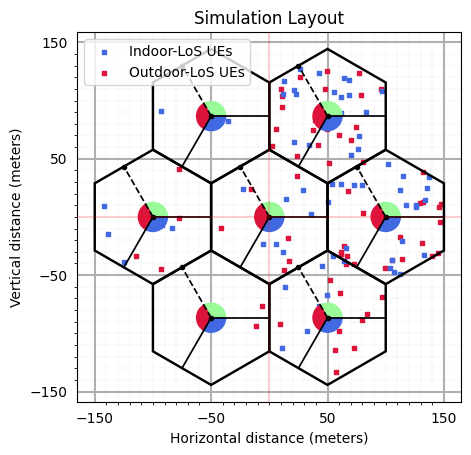

In [8]:
#################################################################
rxPosition  = simLayoutObj.UELocations
txPosition  = simLayoutObj.BSLocations
rangeEst_2D = np.sqrt(np.abs((ToAe*(3*10**8))**2 - (rxPosition[:,2].reshape(1,-1)-txPosition[:,2].reshape(-1,1))**2))

# fig, ax = plt.subplots()
fig, ax = simLayoutObj.display2DTopology(isEqualAspectRatio = True)
colors  = ["k","m","r","b","g","y","crimson"]

linestyle_tuple = ['solid', 'dotted', 'dashed', 'dashdot',
                   (0, (5, 10)),                # 'loosely dashed'
                   (0, (1, 10)),                # 'loosely dotted'
                   (5, (10, 3)),                # 'long dash with offset'
                   (0, (5, 1)),                 # 'densely dashed'
                   (0, (3, 10, 1, 10)),         # 'loosely dashdotted'
                   (0, (3, 5, 1, 5)),           # 'dashdotted'
                   (0, (3, 1, 1, 1)),           # 'densely dashdotted'
                   (0, (3, 5, 1, 5, 1, 5)),     # 'dashdotdotted'
                   (0, (3, 10, 1, 10, 1, 10)),  # 'loosely dashdotdotted'
                   (0, (3, 1, 1, 1, 1, 1))]     # 'densely dashdotdotted'

for nbs in range(k):
    for nue in range(nUEs):
            circle1 = plt.Circle((txPosition[kBestIndices[nue, nbs], 0], txPosition[kBestIndices[nue, nbs], 1]), rangeEst_2D[kBestIndices[nue, nbs], nue],
                                 color = colors[nue%7], lw = 0.35, ls = linestyle_tuple[nue%7], fill = False, zorder = 0)
            ax.add_artist(circle1)

ax.scatter(txPosition[:,0], txPosition[:,1], marker="P", color="b", edgecolors='white',
           s = 125, label="Tx-Locations", zorder = 3)
ax.scatter(rxPositionEstimate[:,0,0], rxPositionEstimate[:,0,1], marker="o", color="g",
           s = 75, label="Estimated Rx-Locations", zorder = 1)
ax.scatter(rxPosition[:,0], rxPosition[:,1], marker=".", color="r", edgecolors='white',
           s = 100, label="True Rx-Locations", zorder = 2)

ax.legend()
ax.set_xlabel("x-coordinates (m)")
ax.set_ylabel("y-coordinates (m)")
ax.set_title("Transmitter's Locations and Estimation Accuracy (True UE Location vs Estimated UE Locations)")
ax.set_xlim([-200, 200])
ax.set_ylim([-200, 200])
ax.grid(True)

## Performance Analysis of Positioning Error for ToA based method

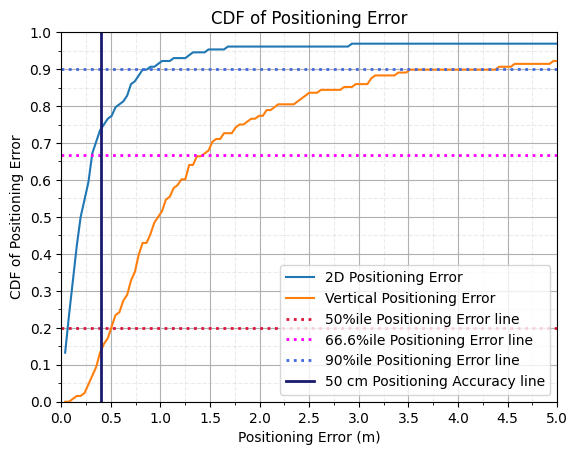

In [9]:
nbins = nUEs
xlimit = 5
ylimit = 1
posError3D = np.linalg.norm(rxPositionEstimate[:,0]-rxPosition, axis=1)
posError3D = np.where(np.isnan(posError3D), 0, posError3D)
posError2D = np.linalg.norm(rxPositionEstimate[:, 0,0:2]-rxPosition[:, 0:2], axis=1)

# Horizontal Error
count, bins_count = np.histogram(posError2D, bins = nbins, range = [0, xlimit])
pdf = count/nUEs
cdf = np.cumsum(pdf)

fig, ax = plt.subplots()
ax.plot(bins_count[1:], cdf, label = "2D Positioning Error")


# Vertical Error
count, bins_count = np.histogram(posError3D, bins = nbins, range = [0, xlimit])
pdf = count/nUEs
cdf = np.cumsum(pdf)
ax.plot(bins_count[1:], cdf, label = "Vertical Positioning Error")

ax.set_xticks(np.linspace(0, xlimit, 11))
ax.set_xticks(np.linspace(0, xlimit, 21), minor=True)
ax.set_yticks(np.linspace(0, ylimit, 11))
ax.set_yticks(np.linspace(0, ylimit, 21), minor=True)
ax.set_xlabel("Positioning Error (m)")
ax.set_ylabel("CDF of Positioning Error")
ax.set_title("CDF of Positioning Error")
ax.axhline(y = 0.2, lw = 2, alpha = 1, linestyle = ':', color = "crimson", label = "50%ile Positioning Error line")
ax.axhline(y = 2/3, lw = 2, alpha = 1, linestyle = ':', color = "magenta", label = "66.6%ile Positioning Error line")
ax.axhline(y = 0.9, lw = 2, alpha = 1, linestyle = ':', color = "royalblue", label = "90%ile Positioning Error line")
ax.axvline(x = 0.4, lw = 2, alpha = 1, linestyle = '-', color = "midnightblue", label = "50 cm Positioning Accuracy line")

# Specify different settings for major and minor grids
ax.grid(which = 'minor', alpha = 0.25, linestyle = '--')
ax.grid(which = 'major', alpha = 1)

ax.set_xlim([0,xlimit])
ax.set_ylim([0,ylimit])
ax.legend()
plt.show()

# # Code to save the Database
# idx  = 0
# flag = True
# while(flag):
#     filename = "Databases/ULTDoA-"+str([idx])+".npz"
#     if(os.path.exists(filename)):
#         idx  = idx + 1
#     else:
#         np.savez(filename, posError3D = posError3D, posError2D = posError2D, 
#                  rxPositionEstimate = rxPositionEstimate, rxPosition = rxPosition, 
#                  ToAe = ToAe, txPosition = txPosition, propTerrain = propTerrain, 
#                  carrierFrequency = carrierFrequency, scs = scs, Nfft = Nfft, 
#                  nBSs = nBSs, nUEs = nUEs, numRBs = numRBs, 
#                  bsArrayStructure  = np.array([1,1,2,2,1]), 
#                  ueArrayStructure  = np.array([1,1,8,4,1]))
#         flag = False

## Performance Analysis: For 2000 UEs

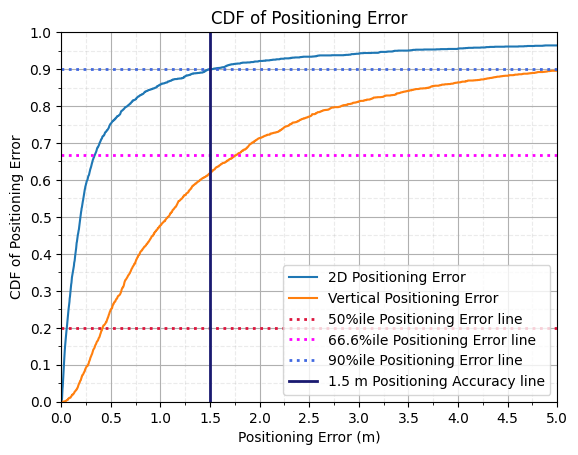

In [14]:
# filename = "Databases/ULTDoA-"+str([0])+".npz"
# ds       = np.load(filename)

# posError3Da = ds["posError3D"]
# posError2Da = ds["posError2D"]

# for i in range(1,idx+1):
    
#     filename   = "Databases/ULTDoA-"+str([i])+".npz"
#     ds         = np.load(filename)
    
#     posError3Da = np.concatenate([posError3Da, ds["posError3D"]])
#     posError2Da = np.concatenate([posError2Da, ds["posError2D"]])


ds       = np.load("Databases/ULTDoA.npz")
posError3Da = ds["posError3D"]
posError2Da = ds["posError2D"]

nbins = posError2Da.size
xlimit = 5
ylimit = 1

# Horizontal Error
count, bins_count = np.histogram(posError2Da, bins = nbins, range = [0, xlimit])
pdf = count/nbins
cdf = np.cumsum(pdf)

fig, ax = plt.subplots()
ax.plot(bins_count[1:], cdf, label = "2D Positioning Error")



# Vertical Error
count, bins_count = np.histogram(posError3Da, bins = nbins, range = [0, xlimit])
pdf = count/nbins
cdf = np.cumsum(pdf)
ax.plot(bins_count[1:], cdf, label = "Vertical Positioning Error")

ax.set_xticks(np.linspace(0, xlimit, 11))
ax.set_xticks(np.linspace(0, xlimit, 21), minor=True)
ax.set_yticks(np.linspace(0, ylimit, 11))
ax.set_yticks(np.linspace(0, ylimit, 21), minor=True)
ax.set_xlabel("Positioning Error (m)")
ax.set_ylabel("CDF of Positioning Error")
ax.set_title("CDF of Positioning Error")
ax.axhline(y = 0.2, lw = 2, alpha = 1, linestyle = ':', color = "crimson", label = "50%ile Positioning Error line")
ax.axhline(y = 2/3, lw = 2, alpha = 1, linestyle = ':', color = "magenta", label = "66.6%ile Positioning Error line")
ax.axhline(y = 0.9, lw = 2, alpha = 1, linestyle = ':', color = "royalblue", label = "90%ile Positioning Error line")
ax.axvline(x = 1.5, lw = 2, alpha = 1, linestyle = '-', color = "midnightblue", label = "1.5 m Positioning Accuracy line")

# Specify different settings for major and minor grids
ax.grid(which = 'minor', alpha = 0.25, linestyle = '--')
ax.grid(which = 'major', alpha = 1)

ax.set_xlim([0,xlimit])
ax.set_ylim([0,ylimit])
ax.legend()
plt.show()